# Testing ⏭ GreedyLR Scheduler for 🤗 LLMs - Design of Experiments

## Prerequisites

In [ ]:
# Reinstall from source to register changes
# May need to restart kernel after install

%pip install -r translation/requirements.txt -q
%pip install -U datasets peft==0.6.0 accelerate trl==0.7.1 -q
%pip install -e ~/transformers/  -q #Or wherever you downloaded this source


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
# May need to add installed version of transformers git repo to python path

import sys
sys.path.insert(0, '~/transformers/')

In [112]:
%load_ext autoreload
%autoreload 2

from transformers import AutoModelForCausalLM, Trainer, AutoTokenizer, TrainingArguments
from transformers import GreedyLR # TODO: resolve import error
from datasets import load_dataset
from peft import PeftModel, LoraConfig

import torch
from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig
from datetime import datetime
from tqdm import tqdm
import json
import json
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Design of Experiments (DOE) Framework

### Select Dataset

In [67]:
dataset = load_dataset("WizardLM/WizardLM_evol_instruct_V2_196k", split="train")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [68]:
# View
dataset["conversations"][0]

[{'from': 'human',
  'value': 'As an online platform teacher named Aimee, you possess impeccable credentials which include a Bachelor of Science degree in Industrial and Labor Relations from Cornell University, expertise in the English language, and intermediate proficiency in both Chinese and Spanish. Additionally, your professional experience as a STEAM teacher at UN Women in Singapore has honed your skills in teaching children from the ages of 6-11 and working with students from all levels of education. Your exceptional teaching abilities in spoken English and pronunciation paired with your personal strengths of being informed, patient, and engaging make you an ideal teacher for students seeking to improve their English language skills. Can you provide a short, concise, and unique English self-introduction in bullet point form that would attract students to enroll in your course?'},
 {'from': 'gpt',
  'value': "Sure, here are some bullet points for your English self-introduction:\n\

### Pre-Process Dataset (if needed)

In [70]:
 def preprocess_evol_instruct(examples):
    """
    Concat prompt-completion pair into a single text string
    """
    pc_pairs = []
    
    for conversation in examples["conversations"]:
        
        instruction = "Human: " + conversation[0]["value"]
        output = "Assistant: " + conversation[1]["value"]
        
        pc_pair = instruction + '\n\n' + output     
        pc_pairs.append(pc_pair)
        
    return {"pc_pairs": pc_pairs}

In [71]:
processed_dataset = dataset.map(preprocess_evol_instruct, batched=True)

Map: 100%|██████████| 143000/143000 [00:12<00:00, 11368.70 examples/s]


In [73]:
# View
print(processed_dataset["pc_pairs"][0])

Human: As an online platform teacher named Aimee, you possess impeccable credentials which include a Bachelor of Science degree in Industrial and Labor Relations from Cornell University, expertise in the English language, and intermediate proficiency in both Chinese and Spanish. Additionally, your professional experience as a STEAM teacher at UN Women in Singapore has honed your skills in teaching children from the ages of 6-11 and working with students from all levels of education. Your exceptional teaching abilities in spoken English and pronunciation paired with your personal strengths of being informed, patient, and engaging make you an ideal teacher for students seeking to improve their English language skills. Can you provide a short, concise, and unique English self-introduction in bullet point form that would attract students to enroll in your course?

Assistant: Sure, here are some bullet points for your English self-introduction:

- Hi there! My name is Aimee and I'm thrilled

### Create list of variable experiment parameters

In [ ]:
# NOTE re: phi-2 LLM
# phi-2 - requires transformer (4.37.0.dev) 
# model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", trust_remote_code=True)
# tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)
# Tokenizer config
# tokenizer.pad_token = tokenizer.eos_token

In [116]:
# TODO: write function to build experiment_configs dictionary
# TODO: add all variables to config dictionary
# TODO: move experiment configs to external config file and read into notebook

experiment_configs = [
    {"model_name": "EleutherAI/gpt-neo-125m", "lr_scheduler_type": "cosine", "r": 16, "lora_alpha": 8, "per_device_train_batch_size": 4},
    {"model_name": "EleutherAI/gpt-neo-125m", "lr_scheduler_type": "greedy", "r": 16, "lora_alpha": 8, "per_device_train_batch_size": 4}
]

### Run Experiments

In [117]:
# Specify dataset name
dataset_name = "WizardLM_evol_instruct_V2_196k"

In [124]:
# TODO: store config dictionary in same folder as output results

def run_experiment(config, dataset_name, processed_dataset):
        
    peft_config = LoraConfig(
        r=config["r"],
        lora_alpha=config["lora_alpha"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )
    
    # Output Directory Variables
    output_prefix = "./experiment_results/" + dataset_name + "/"
    now = datetime.now()
    timestamp = now.strftime("%Y%m%d-%H%M%S")
    output_folder_name = f'{config["model_name"]}_{config["lr_scheduler_type"]}_{timestamp}'
    output_directory = output_prefix + output_folder_name
    
    training_args = TrainingArguments(
        no_cuda=False, # Use CUDA if available
        per_device_train_batch_size=config["per_device_train_batch_size"],
        # gradient_accumulation_steps=4,
        gradient_checkpointing=False,
        max_grad_norm=0.3,
        max_steps=100,
        num_train_epochs=4, 
        learning_rate=1e-3,
        logging_steps=10,
        bf16=True,
        save_steps=100,
        save_total_limit=3,
        output_dir=output_directory,
        optim="adamw_hf",
        lr_scheduler_type=config["lr_scheduler_type"], #Options: "greedy", "constant", "cosine" 
        warmup_ratio=0.05, #for cosine
        factor=0.9 # for greedylr
    )

    trainer = SFTTrainer(
        config["model_name"], # Test options: "EleutherAI/gpt-neo-125m"
        train_dataset=processed_dataset,
        dataset_text_field="pc_pairs",
        max_seq_length=1024,
        peft_config=peft_config,
        args=training_args
    )
    
    trainer.train()
    
    return output_directory

In [125]:
for config in tqdm(experiment_configs):
    print('config params:', config)
    output_directory = run_experiment(config, dataset_name, processed_dataset)
    
    # Save config as json in same experiment folder
    config_file_path = output_directory + '/exp_config.json'
    with open(config_file_path, 'w') as f:
        json.dump(config, f)
        
    print(f'Training logs, checkpoint outputs and experiment config saved to: {output_directory}')

  0%|          | 0/2 [00:00<?, ?it/s]

config params: {'model_name': 'EleutherAI/gpt-neo-125m', 'lr_scheduler_type': 'cosine', 'r': 16, 'lora_alpha': 8, 'per_device_train_batch_size': 4}


Using pad_token, but it is not set yet.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10,1.951400
20,1.839500
30,1.794400
40,1.886600
50,1.994100
60,1.754900
70,1.794500
80,1.765000
90,1.796800
100,1.731100


 50%|█████     | 1/2 [00:29<00:29, 29.49s/it]

Training logs, checkpoint outputs and experiment config saved to: ./experiment_results/WizardLM_evol_instruct_V2_196k/EleutherAI/gpt-neo-125m_cosine_20240219-050708
config params: {'model_name': 'EleutherAI/gpt-neo-125m', 'lr_scheduler_type': 'greedy', 'r': 16, 'lora_alpha': 8, 'per_device_train_batch_size': 4}


/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:124: UserWarning: You passed a model_id to the SFTTrainer. This will automatically create an `AutoModelForCausalLM` or a `PeftModel` (if you passed a `peft_config`) for you.
  warnings.warn(
Using pad_token, but it is not set yet.
/root/transformers/src/transformers/optimization.py:456: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


GreedyLR settings: patience=10 smooth=False min_lr=0.001 factor=0.9


Step,Training Loss
10,1.939300
20,1.830300
30,1.787900
40,1.880800
50,1.985600
60,1.747000
70,1.786200
80,1.752900
90,1.783500
100,1.714000


100%|██████████| 2/2 [00:59<00:00, 29.61s/it]

Training logs, checkpoint outputs and experiment config saved to: ./experiment_results/WizardLM_evol_instruct_V2_196k/EleutherAI/gpt-neo-125m_greedy_20240219-050737


### View Results

In [113]:
def plot_trainer_history(filepath):
  
  with open(filepath) as f:
    data = json.load(f)['log_history'][:-1]

  steps = [log['step'] for log in data]
  lrs = [log['learning_rate'] for log in data]
  losses = [log['loss'] for log in data]

  fig, axs = plt.subplots(1, 2, figsize=(12,5))

  axs[0].plot(steps, lrs, '-')
  axs[0].set_xlabel('Step')
  axs[0].set_ylabel('Learning Rate')
  axs[0].set_title('Learning Rates')

  axs[1].plot(steps, losses, '-')
  axs[1].set_xlabel('Step')
  axs[1].set_ylabel('Loss')
  axs[1].set_title('Losses')

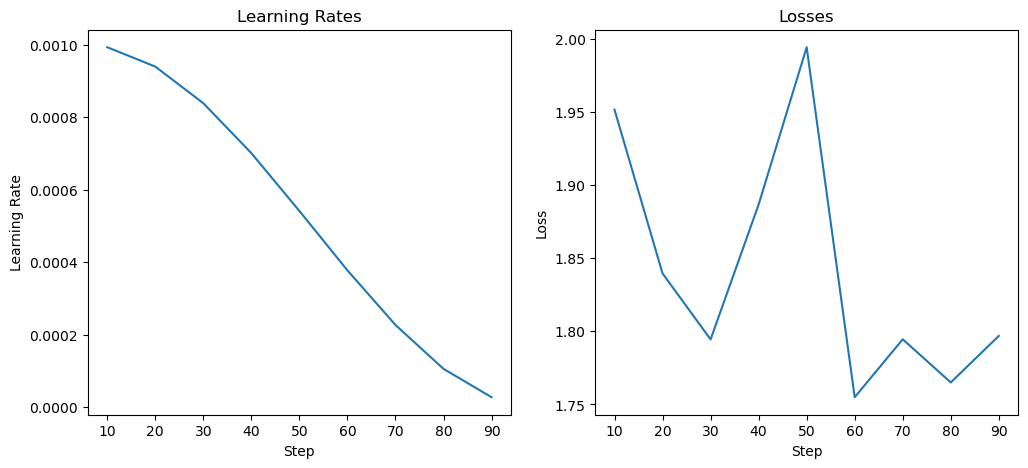

In [126]:
prefix = './experiment_results/WizardLM_evol_instruct_V2_196k/EleutherAI/'
filepath = prefix + 'gpt-neo-125m_cosine_20240219-050708/checkpoint-100/trainer_state.json'
plot_trainer_history(filepath)

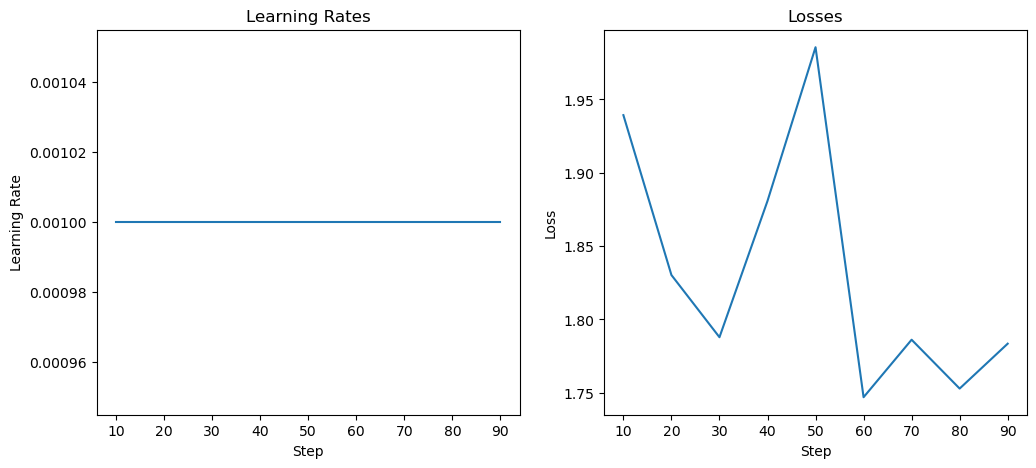

In [127]:
#TODO: Need to investigate why greedyLR is not being applied correctly
prefix = './experiment_results/WizardLM_evol_instruct_V2_196k/EleutherAI/'
filepath = prefix + "gpt-neo-125m_greedy_20240219-050737/checkpoint-100/trainer_state.json"
plot_trainer_history(filepath)